# Analysis of Fidelity Curve Crossings Between d=13 and d=15 as a Function of K

This notebook analyzes how the σ value at which fidelity curves for d=13 and d=15 cross each other changes as a function of K (number of minimum weight matchings).

In [1]:
using JLD2
using Plots
using Statistics

## Load and Examine Data

In [8]:
# Load the data
# data_file = "data/surface_square_mwms_5_15_0.596_0.607_400_3_1023680.jld2"
data_file = "data/qubit_surface_mwms_5_15_0.105_0.115_1000_1_1001744.jld2"
data = load(data_file)

# Extract the main data dictionary
data_dict = data["p_list"]

println("Data loaded successfully!")
println("Number of [σ, d] combinations: ", length(data_dict))

# Extract all unique σ and d values
all_keys = collect(keys(data_dict))
sigma_values = unique([key[1] for key in all_keys])
d_values = unique([key[2] for key in all_keys])

sort!(sigma_values)
sort!(d_values)

println("σ range: ", minimum(sigma_values), " to ", maximum(sigma_values))
println("d values: ", d_values)

# Determine K from the length of the first data vector
first_key = first(all_keys)
K_max = length(data_dict[first_key])
println("Maximum K: ", K_max)

Data loaded successfully!
Number of [σ, d] combinations: 66
σ range: 0.105 to 0.115
d values: [5.0, 7.0, 9.0, 11.0, 13.0, 15.0]
Maximum K: 1001


## Define Function for Finding Curve Crossings

In [9]:
"""
    find_curve_crossing_sigma(sigma_values, fidelity1, fidelity2)

Find the σ value where two fidelity curves cross each other using linear interpolation.

# Arguments
- `sigma_values`: Array of σ values (must be the same for both curves)
- `fidelity1`: Array of fidelity values for first curve (e.g., d=13)
- `fidelity2`: Array of fidelity values for second curve (e.g., d=15)

# Returns
- The σ value at crossing, or NaN if no crossing is found
"""
function find_curve_crossing_sigma(sigma_values, fidelity1, fidelity2)
    # Remove any NaN or missing values from both curves
    valid_indices = .!isnan.(fidelity1) .& .!ismissing.(fidelity1) .& 
                   .!isnan.(fidelity2) .& .!ismissing.(fidelity2)
    
    sigma_clean = sigma_values[valid_indices]
    fidelity1_clean = fidelity1[valid_indices]
    fidelity2_clean = fidelity2[valid_indices]
    
    if length(sigma_clean) < 2
        return NaN
    end
    
    # Sort by sigma values
    sort_indices = sortperm(sigma_clean)
    sigma_sorted = sigma_clean[sort_indices]
    fidelity1_sorted = fidelity1_clean[sort_indices]
    fidelity2_sorted = fidelity2_clean[sort_indices]
    
    # Find crossing points by looking for sign changes in the difference
    diff_values = fidelity1_sorted .- fidelity2_sorted
    
    for i in 1:(length(diff_values)-1)
        d1, d2 = diff_values[i], diff_values[i+1]
        s1, s2 = sigma_sorted[i], sigma_sorted[i+1]
        
        # Check if the difference changes sign (curves cross)
        if (d1 <= 0 <= d2) || (d2 <= 0 <= d1)
            # Linear interpolation to find exact crossing point
            if d2 != d1  # Avoid division by zero
                crossing_sigma = s1 + (0 - d1) * (s2 - s1) / (d2 - d1)
                return crossing_sigma
            end
        end
    end
    
    return NaN  # No crossing found
end

find_curve_crossing_sigma

## Analyze Crossing Points Between d=13 and d=15 Curves

In [10]:
function analyze_curve_crossings(data_dict, d1=13, d2=15)
    """
    Analyze crossing points between fidelity curves for two different distances.
    """
    all_keys = collect(keys(data_dict))
    
    # Extract keys for both distances
    keys_d1 = [key for key in all_keys if key[2] == d1]
    keys_d2 = [key for key in all_keys if key[2] == d2]
    
    if isempty(keys_d1) || isempty(keys_d2)
        println("Warning: Missing data for d=$d1 or d=$d2")
        return Dict()
    end
    
    # Sort by σ and find common σ values
    sort!(keys_d1, by=x->x[1])
    sort!(keys_d2, by=x->x[1])
    
    sigmas_d1 = [key[1] for key in keys_d1]
    sigmas_d2 = [key[1] for key in keys_d2]
    
    # Find common σ values
    common_sigmas = intersect(sigmas_d1, sigmas_d2)
    sort!(common_sigmas)
    
    if length(common_sigmas) < 2
        println("Warning: Not enough common σ values between d=$d1 and d=$d2")
        return Dict()
    end
    
    println("\nAnalyzing crossings between d=$d1 and d=$d2...")
    println("Common σ values: $(length(common_sigmas)) points from $(minimum(common_sigmas)) to $(maximum(common_sigmas))")
    
    # Create lookup dictionaries for faster access
    data_d1 = Dict(key[1] => data_dict[key] for key in keys_d1)
    data_d2 = Dict(key[1] => data_dict[key] for key in keys_d2)
    
    # Determine K_max
    K_max = length(data_d1[common_sigmas[1]])
    
    crossing_sigmas = Float64[]
    k_values = Int[]
    
    for k in 1:K_max
        # Extract fidelity values for this K across common σ values
        fidelities_d1 = [data_d1[sigma][k] for sigma in common_sigmas]
        fidelities_d2 = [data_d2[sigma][k] for sigma in common_sigmas]
        
        # Find crossing point between the two curves
        crossing_sigma = find_curve_crossing_sigma(common_sigmas, fidelities_d1, fidelities_d2)
        
        if !isnan(crossing_sigma)
            push!(crossing_sigmas, crossing_sigma)
            push!(k_values, k)
            if k <= 10 || k % 50 == 0  # Print first 10 and every 50th
                println("  K=$k: d=$d1 and d=$d2 curves cross at σ=$(round(crossing_sigma, digits=4))")
            end
        end
    end
    
    println("Found $(length(crossing_sigmas)) crossings out of $K_max K values")
    
    return Dict(
        "k_values" => k_values,
        "crossing_sigmas" => crossing_sigmas,
        "common_sigmas" => common_sigmas,
        "d1" => d1,
        "d2" => d2
    )
end

# Analyze crossings between d=13 and d=15
results = analyze_curve_crossings(data_dict, 13, 15)


Analyzing crossings between d=13 and d=15...
Common σ values: 11 points from 0.105 to 0.115
Found 0 crossings out of 1001 K values


Dict{String, Any} with 5 entries:
  "crossing_sigmas" => Float64[]
  "k_values"        => Int64[]
  "d1"              => 13
  "common_sigmas"   => [0.105, 0.106, 0.107, 0.108, 0.109, 0.11, 0.111, 0.112, …
  "d2"              => 15

## Visualize Results

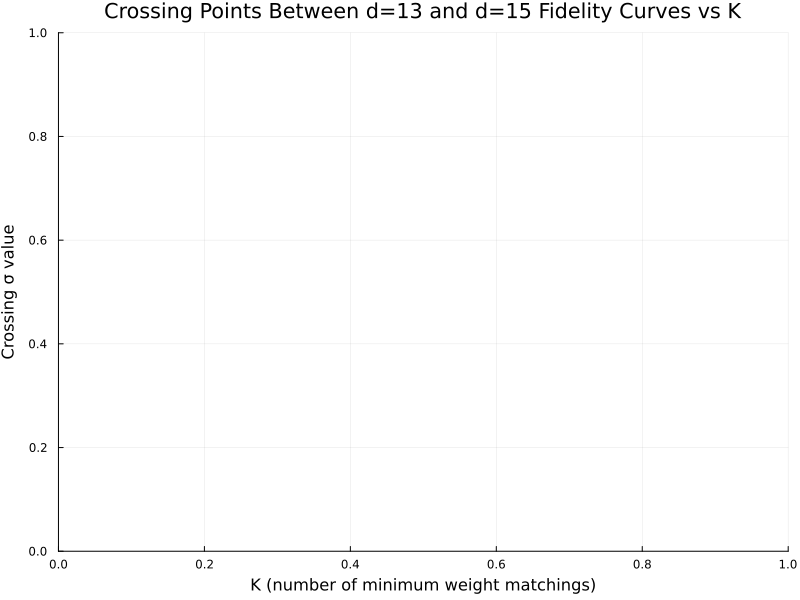

No crossings found between d=13 and d=15 curves


In [11]:
# Plot crossing σ values as a function of K
p = plot(xlabel="K (number of minimum weight matchings)", 
         ylabel="Crossing σ value", 
         title="Crossing Points Between d=13 and d=15 Fidelity Curves vs K",
         legend=:topright,
         size=(800, 600))

if !isempty(results["k_values"])
    plot!(p, results["k_values"], results["crossing_sigmas"], 
          marker=:circle, linewidth=2, markersize=4,
          color=:blue, label="d=13 ∩ d=15 crossing")
else
    println("No crossings found between d=13 and d=15 curves")
end

display(p)

## Detailed Analysis and Summary

In [12]:
println("=== DETAILED SUMMARY ===")
println("Analysis: Crossings between d=$(results["d1"]) and d=$(results["d2"]) fidelity curves")
println()

if !isempty(results["k_values"])
    k_vals = results["k_values"]
    crossing_vals = results["crossing_sigmas"]
    
    println("Number of K values with crossings: $(length(k_vals))")
    println("K range: $(minimum(k_vals)) to $(maximum(k_vals))")
    println("σ_crossing range: $(round(minimum(crossing_vals), digits=4)) to $(round(maximum(crossing_vals), digits=4))")
    println("Common σ range: $(round(minimum(results["common_sigmas"]), digits=4)) to $(round(maximum(results["common_sigmas"]), digits=4))")
    
    if length(crossing_vals) > 1
        # Calculate trend
        trend = crossing_vals[end] - crossing_vals[1]
        trend_per_k = trend / (k_vals[end] - k_vals[1])
        println("Overall trend: σ_crossing changes by $(round(trend, digits=4)) from K=$(k_vals[1]) to K=$(k_vals[end])")
        println("Average change per K: $(round(trend_per_k, digits=6))")
        
        # Calculate correlation
        if length(k_vals) > 2
            correlation = cor(k_vals, crossing_vals)
            println("Correlation between K and σ_crossing: $(round(correlation, digits=4))")
        end
    end
    
    println("\nFirst 20 crossing values:")
    for (i, (k, sigma)) in enumerate(zip(k_vals, crossing_vals))
        if i <= 20
            println("  K=$k: d=13 and d=15 curves cross at σ=$(round(sigma, digits=6))")
        end
    end
    
    if length(k_vals) > 20
        println("  ... (showing first 20 out of $(length(k_vals)) total crossings)")
    end
else
    println("No crossings found between d=13 and d=15 curves")
    println("This could mean:")
    println("  - The curves don't intersect in the available σ range")
    println("  - One curve is always above/below the other")
    println("  - Insufficient data points for interpolation")
end

=== DETAILED SUMMARY ===
Analysis: Crossings between d=13 and d=15 fidelity curves

No crossings found between d=13 and d=15 curves
This could mean:
  - The curves don't intersect in the available σ range
  - One curve is always above/below the other
  - Insufficient data points for interpolation


## Visualize Fidelity Curves for Selected K Values

In [13]:
# Plot fidelity curves for both distances to visualize the crossing behavior
function plot_crossing_fidelity_curves(data_dict, d1, d2, k_values_to_plot=[1, 50, 100])
    all_keys = collect(keys(data_dict))
    
    # Get keys for both distances
    keys_d1 = [key for key in all_keys if key[2] == d1]
    keys_d2 = [key for key in all_keys if key[2] == d2]
    
    sort!(keys_d1, by=x->x[1])
    sort!(keys_d2, by=x->x[1])
    
    # Find common σ values
    sigmas_d1 = [key[1] for key in keys_d1]
    sigmas_d2 = [key[1] for key in keys_d2]
    common_sigmas = intersect(sigmas_d1, sigmas_d2)
    sort!(common_sigmas)
    
    # Create lookup dictionaries
    data_d1 = Dict(key[1] => data_dict[key] for key in keys_d1)
    data_d2 = Dict(key[1] => data_dict[key] for key in keys_d2)
    
    plots_array = []
    
    for k in k_values_to_plot
        if k <= length(data_d1[common_sigmas[1]])
            p = plot(xlabel="σ", ylabel="Fidelity", 
                     title="Fidelity vs σ for K=$k",
                     legend=:topright, size=(600, 400))
            
            # Plot both curves
            fidelities_d1 = [data_d1[sigma][k] for sigma in common_sigmas]
            fidelities_d2 = [data_d2[sigma][k] for sigma in common_sigmas]
            
            plot!(p, common_sigmas, fidelities_d1, 
                  marker=:circle, linewidth=2, markersize=3,
                  color=:blue, label="d=$d1")
            plot!(p, common_sigmas, fidelities_d2, 
                  marker=:square, linewidth=2, markersize=3,
                  color=:red, label="d=$d2")
            
            # Mark crossing point if it exists
            crossing_sigma = find_curve_crossing_sigma(common_sigmas, fidelities_d1, fidelities_d2)
            if !isnan(crossing_sigma)
                # Interpolate fidelity value at crossing
                idx = findfirst(s -> s >= crossing_sigma, common_sigmas)
                if idx !== nothing && idx > 1
                    # Linear interpolation for fidelity at crossing
                    s1, s2 = common_sigmas[idx-1], common_sigmas[idx]
                    f1, f2 = fidelities_d1[idx-1], fidelities_d1[idx]
                    crossing_fidelity = f1 + (crossing_sigma - s1) * (f2 - f1) / (s2 - s1)
                    
                    scatter!(p, [crossing_sigma], [crossing_fidelity], 
                            markersize=8, color=:green, label="Crossing")
                end
            end
            
            push!(plots_array, p)
        end
    end
    
    return plots_array
end

# Plot curves for selected K values
if !isempty(results["k_values"])
    # Select a few representative K values that have crossings
    k_vals = results["k_values"]
    k_to_plot = [k_vals[1]]
    if length(k_vals) > 1
        push!(k_to_plot, k_vals[div(length(k_vals), 2)])
    end
    if length(k_vals) > 2
        push!(k_to_plot, k_vals[end])
    end
    k_to_plot = unique(k_to_plot)
    
    plots_array = plot_crossing_fidelity_curves(data_dict, 13, 15, k_to_plot)
    for p in plots_array
        display(p)
    end
else
    println("No crossings found - cannot plot crossing curves")
end

No crossings found - cannot plot crossing curves


## Save Results

In [ ]:
# Save the crossing analysis results
output_file = "curve_crossing_analysis_results.jld2"
save(output_file, "results", results)
println("Results saved to $output_file")

# Also save as a simple text summary
open("curve_crossing_analysis_summary.txt", "w") do io
    println(io, "Fidelity Curve Crossing Analysis Summary")
    println(io, "Analysis: Crossings between d=$(results["d1"]) and d=$(results["d2"]) curves")
    println(io, "")
    
    if !isempty(results["k_values"])
        k_vals = results["k_values"]
        crossing_vals = results["crossing_sigmas"]
        
        println(io, "Number of crossings found: $(length(k_vals))")
        println(io, "")
        
        for (k, sigma) in zip(k_vals, crossing_vals)
            println(io, "K=$k: σ_crossing = $sigma")
        end
    else
        println(io, "No crossings found between the curves")
    end
end

println("Summary saved to curve_crossing_analysis_summary.txt")